# Concept Vectors (CVs) Demo Notebook

This notebook will help you go through the most important insights from the __[Concept Vectors paper](https://arxiv.org/abs/2503.03666)__.

Note that the aim of notebook is not to go through every low-level implementation in detail, but rather to point you to the most relevant parts in this repository.

## NNsight
The models in this notebook run on the remote __[NDIF](https://ndif.us/)__ server.

This requires you to have an NNsight API key. You can apply for a free API key __[here](https://login.ndif.us/)__ and set it below.

In [ ]:
import nnsight
import os

api_key = os.environ.get("NNSIGHT_API_KEY") # Or simply paste your API key here

if not nnsight.CONFIG.API.APIKEY:
    nnsight.CONFIG.set_default_api_key(api_key)

## Imports

In [2]:
import sys
sys.path.append('..')

import numpy as np
import pickle
import matplotlib.pyplot as plt

from src.utils.ICL_utils import ICLDataset, DatasetConstructor
from src.utils.model_utils import ExtendedLanguageModel
from src.utils.query_utils import get_summed_vec_per_item, compute_similarity_matrix, get_avg_summed_vec, intervene_with_vec, get_completions
from src.utils.eval_utils import SimilarityMatrix, accuracy_completions
from src.utils.globals import DATASET_DIR, RESULTS_DIR

## Extracting and Visualising CVs

In this section we will extract CVs from a sample of prompts used in the paper and visualise them.

We will use the LLama-3.1-70B model.

We will make use of the <code>ExtendedLanguageModel</code> class which is a wrapper around NNsight's <code>LanguageModel</code>. You can set the number of heads you will construct your CV from in the <code>cv_heads_n</code> argument. It defaults to 3 as in the original paper.

In [ ]:
model = ExtendedLanguageModel(model_name='meta-llama/Meta-LLama-3.1-70B', cv_heads_n=3)

We will test our CVs on in-context-learning (ICL) tasks coming from two concepts: 

**antonym** and **categorization** 

Each of them is represented in three low-level formats: 
1. Open-Ended in English
2. Open-Ended in a different language (French/Spanish)
3. Multiple-Choice in English

We will create **20** ICL prompts( **5-shot**) per concept and low-level format (120 in total).

In [ ]:
datasets = [
    'antonym_eng', 
    'antonym_fr', 
    'antonym_eng-mc', 
    'categorical_eng', 
    'categorical_es', 
    'categorical_eng-mc'
]

# DatasetConstructor class is quite project-specific so we won't go into details 
dataset = DatasetConstructor(
    dataset_ids=datasets,
    dataset_size=20, 
    # We set the batch size equal to the dataset size (20) because prompt lengths vary considerably.
    # Multi-choice prompts are notably longer than open-choice ones, leading to excess padding in shorter prompts,
    # which can unexpectedly affect the model's internals.
    batch_size=20,
    n_train=5,
    seed=100
)

Let's print some of the items. The cyan colored part of the prompt is the model's expected completion.

In [ ]:
dataset.datasets[0].pretty_print_item(item=0)

antonym_eng

Q: good
A: bad

Q: real
A: fake

Q: meaningful
A: meaningless

Q: irrelevant
A: relevant

Q: immediate
A: delayed

Q: jerk
A: gentleman

In [ ]:
dataset.datasets[-1].pretty_print_item()

categorical_eng-mc

### Instruction: Q: pink A: 

(a) grain
(b) color
(c) music
(d) bird

### Response: (b)

### Instruction: Q: cobra A: 

(a) snake
(b) fish
(c) fruit
(d) dairy

### Response: (a)

### Instruction: Q: refrigerator A: 

(a) animal
(b) machine
(c) vegetation
(d) place

### Response: (b)

### Instruction: Q: frisbee A: 

(a) toy
(b) fabric
(c) gadget
(d) weapon

### Response: (a)

### Instruction: Q: mango A: 

(a) appliance
(b) toiletry
(c) ocean
(d) fruit

### Response: (d)

### Instruction: Q: albatross A: 

(a) religion
(b) bird
(c) disease
(d) science

### Response: (b

Let's extract the CVs! <code>get_summed_vec_per_item</code> extracts outputs from each a list of attention heads and takes their sum per item (i.e. returing a single vector per prompt). We pass in the heads comprising in the CV, stored in <code>model.cv_heads</code>.

Running this should take ~10 seconds.

In [ ]:
cv_vecs = get_summed_vec_per_item(model=model, dataset=dataset, heads=model.cv_heads)

2025-03-05 17:07:01,245 310b3be9-8d1f-47a0-92ad-c0ffb9e99f0d - RECEIVED: Your job has been received and is waiting approval.
2025-03-05 17:07:02,068 310b3be9-8d1f-47a0-92ad-c0ffb9e99f0d - APPROVED: Your job was approved and is waiting to be run.
2025-03-05 17:07:02,550 310b3be9-8d1f-47a0-92ad-c0ffb9e99f0d - RUNNING: Your job has started running.
2025-03-05 17:07:07,999 310b3be9-8d1f-47a0-92ad-c0ffb9e99f0d - COMPLETED: Your job has been completed.


If NDIF is down or it doesn't work for you for any other reason you can load the vectors here.

In [3]:
cv_vecs = pickle.load(open('data/cvs.pkl', 'rb'))

We see that we now have 120 vectors each of dimensionality of 8192 (corresponding to the size of LLama 70B's residual stream).

In [3]:
cv_vecs.shape

torch.Size([120, 8192])

Let's construct a pairwise similarity matrix for our CVs. <code>compute_similarity_matrix</code> computes cosine similarity for each pair of vectors. As you can the similarity matrix is a square matrix a shape of 120x120 (corresponding to our number of prompts).

In [4]:
cv_simmat = compute_similarity_matrix(cv_vecs).numpy()
cv_simmat.shape

(120, 120)

Let's visualise the similarity matrix! <code>SimilarityMatrix</code> is a generalized helper class to visualise similarity matrices. Throughout the notebook we will demonstrate its most useful properties.

We see that the CVs cluster nicely within the concepts.

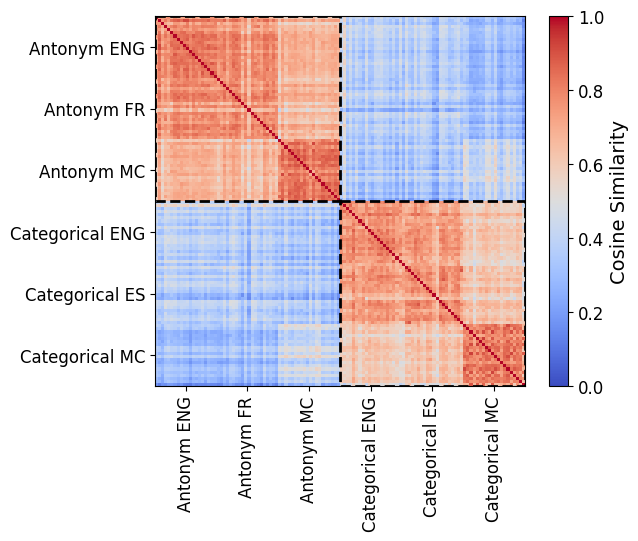

In [5]:
# The names of the individual tasks
tasks = ['Antonym ENG', 'Antonym FR', 'Antonym MC', 'Categorical ENG', 'Categorical ES', 'Categorical MC']
# The names of the concepts that the tasks are based on. This will allow us to draw bounding boxes around the concepts
concepts = ['antonym', 'antonym', 'antonym', 'categorical', 'categorical', 'categorical']

simmat = SimilarityMatrix(
    sim_mat=cv_simmat,
    tasks=tasks,
    attribute_list=concepts
)

simmat.plot(bounding_boxes=True)

We can also relocate the tasks to present the similarity matrix in a different way using the <code>relocate_tasks</code> method. Here we alternate between the concepts. We also modify the plot so that we only show the lower diagonal and plot the mean cosine similairy values for each pair of task.

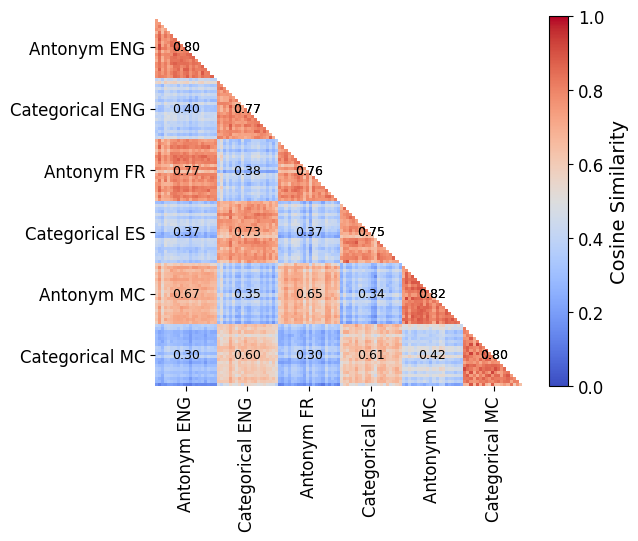

In [8]:
simmat.relocate_tasks([
    'Antonym ENG',
    'Categorical ENG',
    'Antonym FR',
    'Categorical ES',
    'Antonym MC',
    'Categorical MC'
])
simmat.plot(plot_means=True, plot_lower_diag=True)

# Intervention

One of the properties of the CVs is that they can be pasted into model internals to guide its behaviour. We demonstrate this using *AmbigousICL* tasks where we randomly interleave two concepts in the ICL prompt, which makes it ambigous which concept to use to complete the query.

We construct 100 10-shot prompts with the concepts antonym (open-ended in English) and translation (open-ended; English to French).

In [11]:
dataset_intervene = ICLDataset(
    dataset=['antonym_eng', 'english_french'],
    size=100, 
    n_train=10,
    seed=42
)
dataset_intervene.pretty_print_item()

['antonym_eng', 'english_french']

Q: off
A: on

Q: ignore
A: ignorer

Q: insufficient
A: insuffisant

Q: formal
A: formel

Q: valid
A: valide

Q: magical
A: mundane

Q: novel
A: classic

Q: unaccustomed
A: inaccoutumé

Q: abnormal
A: normal

Q: most
A: least

Q: stiff
A: rigide

Q: practical
A: impractical

To intervene on the model and steer it to use the concept 'antonym' and respond **impractical** instead of the french translation **practique** we will construct a single antonym CV. To do this we crate 50 5-shot ICL antonym (open-ended in French) prompts. Using <code>get_avg_summed_vec</code> we then take the average of the attention head outputs over all prompts before summing them into a single vector. Running this cell should take < 10 seconds. 

In [ ]:
dataset_extract = DatasetConstructor('antonym_fr', dataset_size=50, n_train=5, seed=42)
cv_antonym = get_avg_summed_vec(model, dataset_extract, model.cv_heads)
cv_antonym.shape # We get a single vector that matches the size of the model's residual stream

2025-03-04 17:39:30,298 442e7f7f-5d63-4245-b02d-8012052e1d8c - RECEIVED: Your job has been received and is waiting approval.
2025-03-04 17:39:32,071 442e7f7f-5d63-4245-b02d-8012052e1d8c - APPROVED: Your job was approved and is waiting to be run.
2025-03-04 17:39:33,721 442e7f7f-5d63-4245-b02d-8012052e1d8c - RUNNING: Your job has started running.
2025-03-04 17:39:36,364 442e7f7f-5d63-4245-b02d-8012052e1d8c - COMPLETED: Your job has been completed.


torch.Size([8192])

Now using <code>intervene_with_vec</code> we run a forward pass for our prompts where we paste the CV to the model's residual stream at a specified layer. We found the optimal layer to be 31 (stored in <code>model.cv_intervention_layer</code>). We apply 10x scaling to the CV. The output of <code>intervene_with_vec</code> is a list of model completions for all prompts (first-token only). The cell should take < 10 seconds to run.

In [ ]:
completions = intervene_with_vec(
    model=model, 
    dataset=dataset_intervene, 
    vector=cv_antonym*10, 
    layers=model.cv_intervention_layer
)
completions = completions[model.cv_intervention_layer] # intervene_with_vec returns a dict {layer: completions}

2025-03-04 17:45:44,409 f9161b00-3e69-4b83-a597-18c886f3f8e7 - RECEIVED: Your job has been received and is waiting approval.
2025-03-04 17:45:45,217 f9161b00-3e69-4b83-a597-18c886f3f8e7 - APPROVED: Your job was approved and is waiting to be run.
2025-03-04 17:45:45,842 f9161b00-3e69-4b83-a597-18c886f3f8e7 - RUNNING: Your job has started running.
2025-03-04 17:45:46,150 f9161b00-3e69-4b83-a597-18c886f3f8e7 - LOG: Layer: 31
2025-03-04 17:45:51,079 f9161b00-3e69-4b83-a597-18c886f3f8e7 - COMPLETED: Your job has been completed.


In [16]:
accuracy_completions(model, completions, dataset_intervene.completions)

0.46